# Circle Detection ML Challenge

The goal of this challenge is to develop a **circle detector** that can find the location of a circle in an image with arbitrary noise. Your goal is to produce a deep learning model that can take an image as input and produce as output the location of the circle’s center (`x,y`) and its radius.

To get you started, we’ve provided some helper functions for generating example images. You can use the `noisy_circle` function to generate a square image with a circle randomly drawn on it and with added noise, along with the parameters `(x,y,r)`. The  `show_circle` function can be used to display a circle and see what it looks like. The `generate_examples` function provides an infinite generator with examples and corresponding parameters, and the `iou` function can be used to calculate the “[intersection over union](https://en.wikipedia.org/wiki/Jaccard_index)” (IOU) metric between the true location of the circle in the image and the predicted location. 

As a test metric, we recommend accuracy based on thresholded IOU, because of its intuitive nature. For example, you can calculate the % of test examples where the predicted circle overlaps pretty closely with the actual circle - i.e. where IOU ≥ 0.5, 0.75, 0.9, or 0.95. 

This project should ideally take around two hours (other than training time), with some experience training CNNs. We recommend using Colab for GPU training. A model with ~10M parameters is probably enough, although you can probably achieve high accuracy with substantially fewer. If you find it helpful, you’re welcome to play around with lower (or higher) noise parameters or starting with smaller images for faster training times. 

Along with the model weights and code, please provide a short report, which can be in the form of a `README.md` explaining how the code works and the model’s final metrics. We care a lot about code quality, so we definitely recommend formatting your code nicely (e.g. using JetBrains or `black`), and using typing and/or comments where it’s helpful.

In [ ]:
from typing import NamedTuple, Optional, Tuple, Generator

import numpy as np
from matplotlib import pyplot as plt
from skimage.draw import circle_perimeter_aa


class CircleParams(NamedTuple):
    row: int
    col: int
    radius: int


def draw_circle(img: np.ndarray, row: int, col: int, radius: int) -> np.ndarray:
    """
    Draw a circle in a numpy array, inplace.
    The center of the circle is at (row, col) and the radius is given by radius.
    The array is assumed to be square.
    Any pixels outside the array are ignored.
    Circle is white (1) on black (0) background, and is anti-aliased.
    """
    rr, cc, val = circle_perimeter_aa(row, col, radius)
    valid = (rr >= 0) & (rr < img.shape[0]) & (cc >= 0) & (cc < img.shape[1])
    img[rr[valid], cc[valid]] = val[valid]
    return img


def noisy_circle(
    img_size: int, min_radius: float, max_radius: float, noise_level: float
) -> Tuple[np.ndarray, CircleParams]:
    """
    Draw a circle in a numpy array, with normal noise.
    """

    # Create an empty image
    img = np.zeros((img_size, img_size))

    radius = np.random.randint(min_radius, max_radius)

    # x,y coordinates of the center of the circle
    row, col = np.random.randint(img_size, size=2)

    # Draw the circle inplace
    draw_circle(img, row, col, radius)

    added_noise = np.random.normal(0.5, noise_level, img.shape)
    img += added_noise

    return img, CircleParams(row, col, radius)


def show_circle(img: np.ndarray):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_title('Circle')
    plt.show()


def generate_examples(
    noise_level: float = 0.5,
    img_size: int = 100,
    min_radius: Optional[int] = None,
    max_radius: Optional[int] = None,
    dataset_path: str = 'ds',
) -> Generator[Tuple[np.ndarray, CircleParams], None, None]:
    if not min_radius:
        min_radius = img_size // 10
    if not max_radius:
        max_radius = img_size // 2
    assert max_radius > min_radius, "max_radius must be greater than min_radius"
    assert img_size > max_radius, "size should be greater than max_radius"
    assert noise_level >= 0, "noise should be non-negative"

    params = f"{noise_level=}, {img_size=}, {min_radius=}, {max_radius=}, {dataset_path=}"
    print(f"Using parameters: {params}")
    while True:
        img, params = noisy_circle(
            img_size=img_size, min_radius=min_radius, max_radius=max_radius, noise_level=noise_level
        )
        yield img, params


def iou(a: CircleParams, b: CircleParams) -> float:
    """Calculate the intersection over union of two circles"""
    r1, r2 = a.radius, b.radius
    d = np.linalg.norm(np.array([a.row, a.col]) - np.array([b.row, b.col]))
    if d > r1 + r2:
        return 0
    if d <= abs(r1 - r2):
        return 1
    r1_sq, r2_sq = r1**2, r2**2
    d1 = (r1_sq - r2_sq + d**2) / (2 * d)
    d2 = d - d1
    h1 = r1_sq * np.arccos(d1 / r1)
    h2 = d1 * np.sqrt(r1_sq - d1**2)
    h3 = r2_sq * np.arccos(d2 / r2)
    h4 = d2 * np.sqrt(r2_sq - d2**2)
    intersection = h1 + h2 + h3 + h4
    union = np.pi * (r1_sq + r2_sq) - intersection
    return intersection / union

## Solution

In [ ]:
def denoise_example(
    example: Tuple[np.ndarray, CircleParams
]) -> Tuple[np.ndarray, CircleParams]:
    """
    Produce a "denoised" version of a given noisy example.
    """

    # Create an empty image

    img = example[0]
    img = np.zeros_like(img)

    # Draw the circle inplace
    
    circle_params = example[1]

    draw_circle(
        img, 
        circle_params.row, 
        circle_params.col, 
        circle_params.radius,
    )

    return img, circle_params

In [ ]:
examples = generate_examples()

In [ ]:
example1 = next(examples)

Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


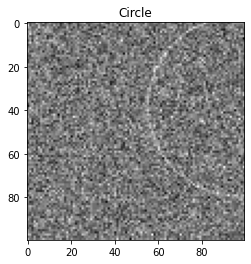

In [ ]:
show_circle(example1[0])

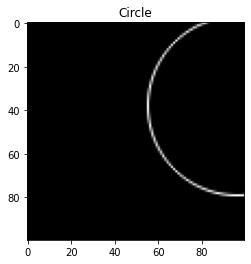

In [ ]:
show_circle(denoise_example(example1)[0])

In [ ]:
def create_dataset(
    number_of_examples: int = 10_000
):
    X = []
    y = []
    examples = generate_examples()

    for _ in range(number_of_examples):
        image, circle_parameters = next(examples)

        label = np.array([
            circle_parameters.row, 
            circle_parameters.col,
            circle_parameters.radius
        ])

        X.append(image)
        y.append(label) #y.append(denoise_example((image, circle_parameters))[0])
    
    return np.array(X), np.array(y)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the input shape
input_shape = (100, 100, 1)

# Initialize the model
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

# Add the second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Add the third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Add the fourth convolutional layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer with 128 neurons
model.add(Dense(3))
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 128)     

In [ ]:
X_train, y_train = create_dataset()

Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


In [ ]:
#X_test, y_test = create_dataset()

In [ ]:
X_validation, y_validation = create_dataset(3000)

Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


In [ ]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation))

Epoch 1/20
313/313 [==============================] - 4s 14ms/step - loss: 43.7853 - accuracy: 0.9237 - val_loss: 37.7778 - val_accuracy: 0.9370
Epoch 2/20
313/313 [==============================] - 5s 15ms/step - loss: 30.5152 - accuracy: 0.9327 - val_loss: 41.4870 - val_accuracy: 0.9387
Epoch 3/20
313/313 [==============================] - 4s 14ms/step - loss: 24.1887 - accuracy: 0.9391 - val_loss: 35.3310 - val_accuracy: 0.9347
Epoch 4/20
313/313 [==============================] - 5s 15ms/step - loss: 19.7668 - accuracy: 0.9445 - val_loss: 35.6561 - val_accuracy: 0.9357
Epoch 5/20
313/313 [==============================] - 5s 15ms/step - loss: 17.1693 - accuracy: 0.9482 - val_loss: 40.3021 - val_accuracy: 0.9353
Epoch 6/20
183/313 [================>.............] - ETA: 1s - loss: 14.6735 - accuracy: 0.9525

KeyboardInterrupt: ignored

In [ ]:
model_preds = model(X_validation)

In [ ]:
ious = [iou(CircleParams(*yp), CircleParams(*y)) for yp, y in zip(model_preds, y_validation)]

In [ ]:
import seaborn as sns


/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

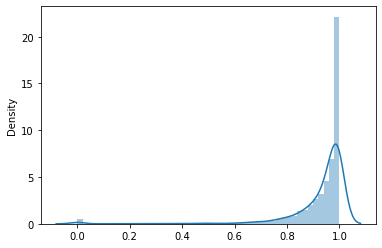

In [ ]:
sns.distplot(ious)

In [ ]:
np.mean(ious), np.var(ious)

(0.9286026409442226, 0.017898259706749266)

We can see that the model achieves a high IOU score most of the time with an average of 92%.

In [ ]:
model.save('circle_detector.h5')